In [96]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import sys
import csv
import pandas as pd
import os
os.path.abspath(os.path.join(os.getcwd(), '../PwElasticWorkChain/'))


def string_to_tuple(stringin):
    #transform voigt index string to matrix tuple
    return tuple([int(i)-1 for i in stringin])


def tuple_value_list_to_matrix(tuples_values_list):
    matrix = np.zeros((6,6))
    for i in tuples_values_list:
        t,v = string_to_tuple(i[0]), i[1]
        symmt = tuple(reversed(t))
        #print i[0], t, symmt
        matrix[t] = v
        matrix[symmt] = v
    return matrix


def get_elastic_symmetries_old(laue, df = pd.read_csv('./elastic_paper_table.csv', dtype=str), returntype = 'matrix'):
    indcomp = []
    comp_values = []
    components = df['N'].tolist()
    
    for line, comp in zip(df[laue].tolist(), components):
        if line == 'A*':
            indcomp.extend(['11','12'])
        else:
            res = line.split('*')
            # the component is multiplied by some value
            if len(res) == 2:
                indcomp.append(res[1])
            # the component is not multiplied by a value and is not 0
            elif res[0] != '0':
                indcomp.append(res[0])

    independentconstants = list(set(indcomp))
    #Checked: works correctly
    
    symmetriesdict = {i:[] for i in independentconstants}
    # We keep the standard names for the constants a keys
    # for the dict
    # later we can standardize
    
    for line, comp in zip(df[laue].tolist(), components):
            #comp is the position in the elastic matrix
            #i.e. the position in the symmetry matrix
            #line is what the value at the position is
            #that might be e.g. another constant
            
            if line == 'A*':
                symmetriesdict['11'].append( (comp, 0.5) )
                symmetriesdict['12'].append( (comp, -0.5) )
            else:
                res = line.split('*')
                if len(res) == 2:
                    symmetriesdict[res[1]].append((comp, int(res[0])))
                elif res[0] != '0':
                    symmetriesdict[res[0]].append((comp, 1))
                    
                    
    symmetry_matrices = []
    symmetry_matrices_dict =    {k: tuple_value_list_to_matrix(v)  for  k, v in symmetriesdict.items()}
    
    for kl in sorted(symmetry_matrices_dict.keys()):
        symmetry_matrices.append(symmetry_matrices_dict[kl])
    if returntype == 'matrix':
        return np.array(symmetry_matrices)
    else:
        return symmetry_matrices_dict


# We have different values here. Why??

In [45]:

%load_ext autoreload
%autoreload 2

# to get windows that pop up (where we can zoom etc.)
#%pylab notebook
#%matplotlib
%matplotlib notebook

import pylab as plt



import sys,json
import numpy as np
import pickle



#with open('allproperties.json', 'r') as o:
#    allproperties = json.load(o)
    
#allproperties.keys()
from mpl_toolkits.axes_grid1 import make_axes_locatable
params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)

params = {'text.usetex': True,
	    'text.latex.preamble': [r'\usepackage{cmbright}', r'\usepackage{amsmath}']}
plt.rcParams.update(params)
plt.rcParams['text.latex.preamble'] = [
    r'\usepackage{siunitx}',  # i need upright \micro symbols, but you need...
    r'\sisetup{detect-all}',  # ...this to force siunitx to actually use your fonts
    r'\usepackage{helvet}',  # set the normal font here
    r'\usepackage{sfmath}',  # load up the sansmath so that math -> helvet
    # r'\sfmath'               # <- tricky! -- gotta actually tell tex to use!
]



    
from sklearn.manifold import TSNE
from matplotlib import cm


#%pylab notebook
#%matplotlib
%matplotlib notebook

import numpy as np

from olics import *

from elastic_utils import laue_names, get_min_number_of_strains, ulics
from pathos.multiprocessing import ProcessingPool

from multiprocessing import Pool

import numpy as np
import scipy.optimize as spopt




def calc_cost(symm_mat, num_strains, num_dims=6, optimality = 'D'):
    return lambda x0: doe_cost(x0, symm_mat, num_strains, num_dims=num_dims, optimality = optimality)


def run_Basin_hopping(symm_mat, num_strains, num_dims=6, cij_guess=None,
          optimality = 'D' , method='SLSQP', tol=0.01, num_itermax=1000, stepsize=0.2, temp = 10, ortho = True):
    
    return lambda x0: optimize_basin_hopping(x0, symm_mat, num_strains, num_dims=num_dims, cij_guess=cij_guess,
          optimality = optimality , method=method, tol=tol, num_itermax=num_itermax, stepsize=stepsize, temp = temp, ortho=ortho)


import pickle
import time

#General Parameters

test = False

num_dims=6
cij_guess=None
optimality = 'D'
method='SLSQP'
tol=0.03

from matplotlib.font_manager import FontProperties

temperatures = 'auto'

if test:

    num_itermax=1000
    num_itermax_tsne = 5000
    random_tests = 1000
    basin_tests = 4
    stepsize=0.1
    ortho = True

else:
    num_itermax=10000
    num_itermax_tsne = 5000
    random_tests = 20000
    basin_tests = 4
    stepsize=0.1
    ortho = True       




np.set_printoptions(precision=3, floatmode='fixed')  
lk = sorted(laue_names.keys())

print lk


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['CI', 'CII', 'HI', 'HII', 'Mb', 'Mc', 'N', 'O', 'RI', 'RII', 'TI', 'TII']


In [153]:
!pwd

/home/azadoks/git/OLICS


In [2]:
import json
help(json.dump)

Help on function dump in module json:

dump(obj, fp, *, skipkeys=False, ensure_ascii=True, check_circular=True, allow_nan=True, cls=None, indent=None, separators=None, default=None, sort_keys=False, **kw)
    Serialize ``obj`` as a JSON formatted stream to ``fp`` (a
    ``.write()``-supporting file-like object).
    
    If ``skipkeys`` is true then ``dict`` keys that are not basic types
    (``str``, ``int``, ``float``, ``bool``, ``None``) will be skipped
    instead of raising a ``TypeError``.
    
    If ``ensure_ascii`` is false, then the strings written to ``fp`` can
    contain non-ASCII characters if they appear in strings contained in
    ``obj``. Otherwise, all such characters are escaped in JSON strings.
    
    If ``check_circular`` is false, then the circular reference check
    for container types will be skipped and a circular reference will
    result in an ``OverflowError`` (or worse).
    
    If ``allow_nan`` is false, then it will be a ``ValueError`` to
    serializ

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
run CI (1 strains)
strains random
done
ortho strains random
done
here orthoruns
done
here
done
done
done
getting histograms
optstrainsortho_normalization
[[1.0], [1.0], [1.0], [1.0]]
plotting


/home/nicolas/.virtualenvs/standard/lib/python2.7/site-packages/ipykernel_launcher.py:258: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/nicolas/.virtualenvs/standard/lib/python2.7/site-packages/ipykernel_launcher.py:263: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/nicolas/.virtualenvs/standard/lib/python2.7/site-packages/ipykernel_launcher.py:268: VisibleDeprecationWarning: Pass

<IPython.core.display.Javascript object>


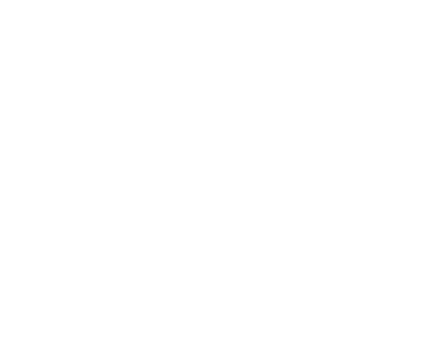

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 5005 samples in 0.003s...
[t-SNE] Computed neighbors for 5005 samples in 0.188s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5005
[t-SNE] Computed conditional probabilities for sample 2000 / 5005
[t-SNE] Computed conditional probabilities for sample 3000 / 5005
[t-SNE] Computed conditional probabilities for sample 4000 / 5005
[t-SNE] Computed conditional probabilities for sample 5000 / 5005
[t-SNE] Computed conditional probabilities for sample 5005 / 5005
[t-SNE] Mean sigma: 0.102687
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.254860
[t-SNE] KL divergence after 5000 iterations: 1.901881
finished for 0p577 (CI strain 1) after vector min
run CII (1 strains)
strains random
done
ortho strains random
done
here orthoruns
done
here
done
done
done
getting histograms
optstrainsortho_normalization
[[1.0], [0.9999999999999999], [1.0], [0.9999999999999999]]
plotting


<IPython.core.display.Javascript object>


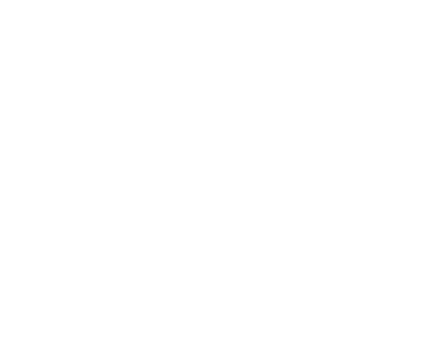

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 5005 samples in 0.002s...
[t-SNE] Computed neighbors for 5005 samples in 0.179s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5005
[t-SNE] Computed conditional probabilities for sample 2000 / 5005
[t-SNE] Computed conditional probabilities for sample 3000 / 5005
[t-SNE] Computed conditional probabilities for sample 4000 / 5005
[t-SNE] Computed conditional probabilities for sample 5000 / 5005
[t-SNE] Computed conditional probabilities for sample 5005 / 5005
[t-SNE] Mean sigma: 0.102033
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.130203
[t-SNE] KL divergence after 5000 iterations: 1.909886
finished for 0p578 (CII strain 1) after vector min
run HI (2 strains)
strains random
done
ortho strains random
done
here orthoruns
done
here
done
done
done
getting histograms
optstrainsortho_normalization
[[0.9999999999999999, 1.0], [0.9999999999999999, 1.0], [1.0, 1.0], [0.9999999999999999, 0.9999999

<IPython.core.display.Javascript object>


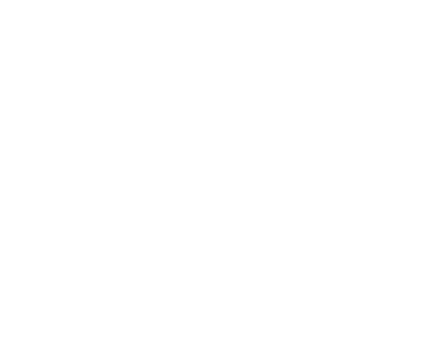

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 5009 samples in 0.003s...
[t-SNE] Computed neighbors for 5009 samples in 0.679s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5009
[t-SNE] Computed conditional probabilities for sample 2000 / 5009
[t-SNE] Computed conditional probabilities for sample 3000 / 5009
[t-SNE] Computed conditional probabilities for sample 4000 / 5009
[t-SNE] Computed conditional probabilities for sample 5000 / 5009
[t-SNE] Computed conditional probabilities for sample 5009 / 5009
[t-SNE] Mean sigma: 0.193736
[t-SNE] KL divergence after 50 iterations with early exaggeration: 91.593452
[t-SNE] KL divergence after 5000 iterations: 2.935375
finished for 2p33 (HI strain 2) after vectors min
run HII (2 strains)
strains random
done
ortho strains random
done
here orthoruns
done
here
done
done
done
getting histograms
optstrainsortho_normalization
[[0.9999999999999999, 0.9999999999999998], [1.0, 1.0], [1.0, 1.0], [0.9999999999999999, 1.0], [1.0

<IPython.core.display.Javascript object>


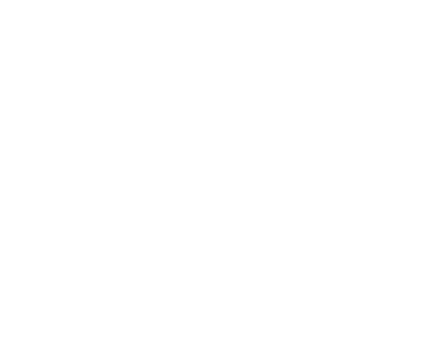

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 5009 samples in 0.002s...
[t-SNE] Computed neighbors for 5009 samples in 0.677s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5009
[t-SNE] Computed conditional probabilities for sample 2000 / 5009
[t-SNE] Computed conditional probabilities for sample 3000 / 5009
[t-SNE] Computed conditional probabilities for sample 4000 / 5009
[t-SNE] Computed conditional probabilities for sample 5000 / 5009
[t-SNE] Computed conditional probabilities for sample 5009 / 5009
[t-SNE] Mean sigma: 0.193961
[t-SNE] KL divergence after 50 iterations with early exaggeration: 91.613258
[t-SNE] KL divergence after 5000 iterations: 2.937441
finished for 2p49 (HII strain 2) after vectors min
run Mb (5 strains)
strains random
done
ortho strains random
done
here orthoruns
done
here
done
done
done
getting histograms
optstrainsortho_normalization
[[1.0, 1.0, 1.0, 1.0000000000000002, 1.0], [1.0, 0.9999999999999998, 1.0, 1.0, 0.9999999999999999]

<IPython.core.display.Javascript object>


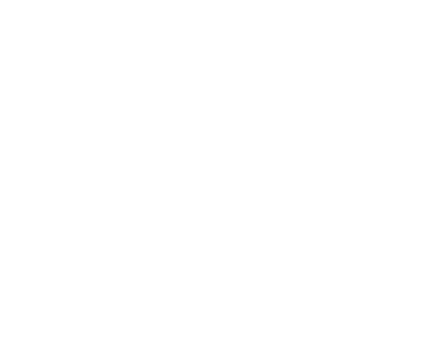

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 5021 samples in 0.005s...
[t-SNE] Computed neighbors for 5021 samples in 1.458s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5021
[t-SNE] Computed conditional probabilities for sample 2000 / 5021
[t-SNE] Computed conditional probabilities for sample 3000 / 5021
[t-SNE] Computed conditional probabilities for sample 4000 / 5021
[t-SNE] Computed conditional probabilities for sample 5000 / 5021
[t-SNE] Computed conditional probabilities for sample 5021 / 5021
[t-SNE] Mean sigma: 0.314645
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.448853
[t-SNE] KL divergence after 5000 iterations: 3.703852
finished for 0p0 (Mb strain 5) after vectors min
run Mc (5 strains)
strains random
done
ortho strains random
done
here orthoruns
done
here
done
done
done
getting histograms
optstrainsortho_normalization
[[1.0, 1.0, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999], [1.0, 1.0, 0.9999999999999

<IPython.core.display.Javascript object>


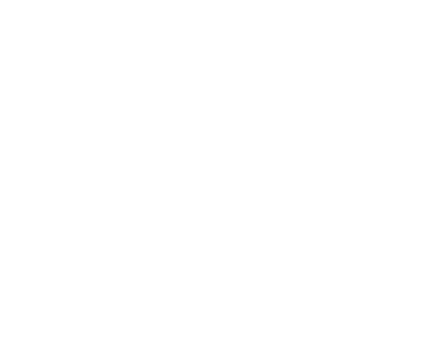

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 5021 samples in 0.005s...
[t-SNE] Computed neighbors for 5021 samples in 1.468s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5021
[t-SNE] Computed conditional probabilities for sample 2000 / 5021
[t-SNE] Computed conditional probabilities for sample 3000 / 5021
[t-SNE] Computed conditional probabilities for sample 4000 / 5021
[t-SNE] Computed conditional probabilities for sample 5000 / 5021
[t-SNE] Computed conditional probabilities for sample 5021 / 5021
[t-SNE] Mean sigma: 0.315316
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.442497
[t-SNE] KL divergence after 5000 iterations: 3.711935
finished for 0p0 (Mc strain 5) after vectors min
run N (6 strains)
strains random
done
ortho strains random
done
here orthoruns
done
here
done
done
done
getting histograms
optstrainsortho_normalization
[[0.9999999999999999, 0.9999999999999999, 0.9999999999999998, 0.9999999999999998, 1.0, 0.99999999999

<IPython.core.display.Javascript object>


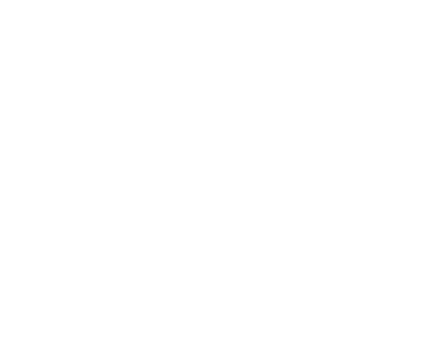

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 5025 samples in 0.005s...
[t-SNE] Computed neighbors for 5025 samples in 1.565s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5025
[t-SNE] Computed conditional probabilities for sample 2000 / 5025
[t-SNE] Computed conditional probabilities for sample 3000 / 5025
[t-SNE] Computed conditional probabilities for sample 4000 / 5025
[t-SNE] Computed conditional probabilities for sample 5000 / 5025
[t-SNE] Computed conditional probabilities for sample 5025 / 5025
[t-SNE] Mean sigma: 0.338754
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.262184
[t-SNE] KL divergence after 5000 iterations: 3.816619
finished for 0p0 (N strain 6) after vectors min
run O (3 strains)
strains random
done
ortho strains random
done
here orthoruns
done
here
done
done
done
getting histograms
optstrainsortho_normalization
[[1.0, 0.9999999999999999, 1.0], [1.0, 1.0, 0.9999999999999999], [1.0, 1.0000000000000002, 1.0], [1.0

<IPython.core.display.Javascript object>


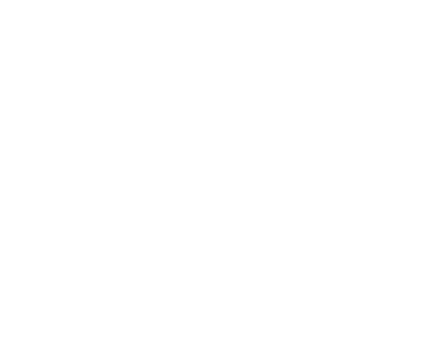

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 5013 samples in 0.003s...
[t-SNE] Computed neighbors for 5013 samples in 1.018s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5013
[t-SNE] Computed conditional probabilities for sample 2000 / 5013
[t-SNE] Computed conditional probabilities for sample 3000 / 5013
[t-SNE] Computed conditional probabilities for sample 4000 / 5013
[t-SNE] Computed conditional probabilities for sample 5000 / 5013
[t-SNE] Computed conditional probabilities for sample 5013 / 5013
[t-SNE] Mean sigma: 0.248798
[t-SNE] KL divergence after 50 iterations with early exaggeration: 91.114929
[t-SNE] KL divergence after 5000 iterations: 3.372354
finished for 34p239 (O strain 3) after vectors min
run RI (2 strains)
strains random
done
ortho strains random
done
here orthoruns
done
here
done
done
done
getting histograms
optstrainsortho_normalization
[[1.0000000000000002, 1.0], [1.0, 1.0], [0.9999999999999999, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1

<IPython.core.display.Javascript object>


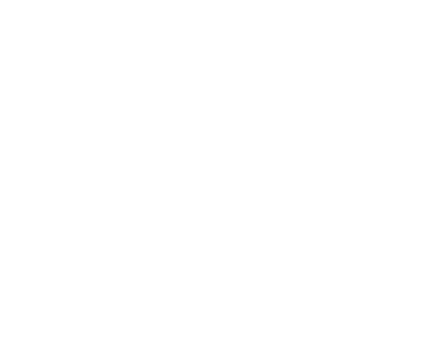

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 5009 samples in 0.003s...
[t-SNE] Computed neighbors for 5009 samples in 0.674s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5009
[t-SNE] Computed conditional probabilities for sample 2000 / 5009
[t-SNE] Computed conditional probabilities for sample 3000 / 5009
[t-SNE] Computed conditional probabilities for sample 4000 / 5009
[t-SNE] Computed conditional probabilities for sample 5000 / 5009
[t-SNE] Computed conditional probabilities for sample 5009 / 5009
[t-SNE] Mean sigma: 0.195482
[t-SNE] KL divergence after 50 iterations with early exaggeration: 91.656311
[t-SNE] KL divergence after 5000 iterations: 2.951891
finished for 1p888 (RI strain 2) after vectors min
run RII (2 strains)
strains random
done
ortho strains random
done
here orthoruns
done
here
done
done
done
getting histograms
optstrainsortho_normalization
[[1.0, 0.9999999999999999], [1.0, 0.9999999999999999], [1.0, 0.9999999999999998], [1.000000000000

<IPython.core.display.Javascript object>


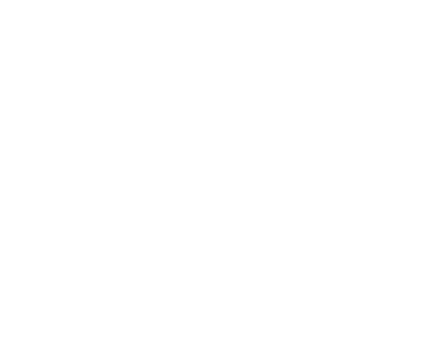

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 5009 samples in 0.003s...
[t-SNE] Computed neighbors for 5009 samples in 0.678s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5009
[t-SNE] Computed conditional probabilities for sample 2000 / 5009
[t-SNE] Computed conditional probabilities for sample 3000 / 5009
[t-SNE] Computed conditional probabilities for sample 4000 / 5009
[t-SNE] Computed conditional probabilities for sample 5000 / 5009
[t-SNE] Computed conditional probabilities for sample 5009 / 5009
[t-SNE] Mean sigma: 0.194362
[t-SNE] KL divergence after 50 iterations with early exaggeration: 91.624489
[t-SNE] KL divergence after 5000 iterations: 2.925669
finished for 1p522 (RII strain 2) after vectors min
run TI (2 strains)
strains random
done
ortho strains random
done
here orthoruns
done
here
done
done
done
getting histograms
optstrainsortho_normalization
[[0.9999999999999999, 0.9999999999999999], [1.0, 0.9999999999999999], [1.0, 0.9999999999999999], 

<IPython.core.display.Javascript object>


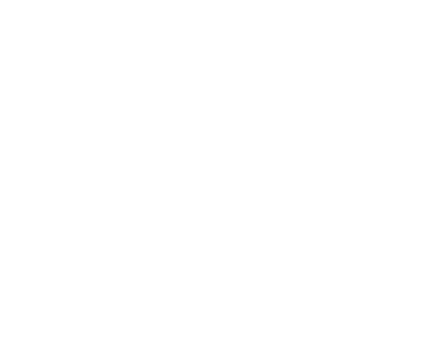

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 5009 samples in 0.002s...
[t-SNE] Computed neighbors for 5009 samples in 0.677s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5009
[t-SNE] Computed conditional probabilities for sample 2000 / 5009
[t-SNE] Computed conditional probabilities for sample 3000 / 5009
[t-SNE] Computed conditional probabilities for sample 4000 / 5009
[t-SNE] Computed conditional probabilities for sample 5000 / 5009
[t-SNE] Computed conditional probabilities for sample 5009 / 5009
[t-SNE] Mean sigma: 0.195308
[t-SNE] KL divergence after 50 iterations with early exaggeration: 91.664688
[t-SNE] KL divergence after 5000 iterations: 2.911793
finished for 8p433 (TI strain 2) after vectors min
run TII (2 strains)
strains random
done
ortho strains random
done
here orthoruns
done
here
done
done
done
getting histograms
optstrainsortho_normalization
[[1.0, 1.0], [0.9999999999999999, 0.9999999999999998], [0.9999999999999999, 0.9999999999999999], 

<IPython.core.display.Javascript object>


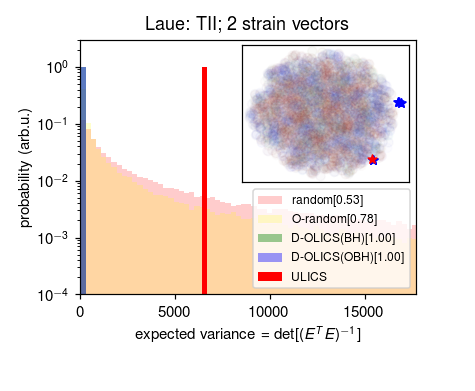

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 5009 samples in 0.002s...
[t-SNE] Computed neighbors for 5009 samples in 0.680s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5009
[t-SNE] Computed conditional probabilities for sample 2000 / 5009
[t-SNE] Computed conditional probabilities for sample 3000 / 5009
[t-SNE] Computed conditional probabilities for sample 4000 / 5009
[t-SNE] Computed conditional probabilities for sample 5000 / 5009
[t-SNE] Computed conditional probabilities for sample 5009 / 5009
[t-SNE] Mean sigma: 0.194024
[t-SNE] KL divergence after 50 iterations with early exaggeration: 91.653351
[t-SNE] KL divergence after 5000 iterations: 2.923850
finished for 15p307 (TII strain 2) after vectors min


In [46]:

%load_ext autoreload
%autoreload 2

# to get windows that pop up (where we can zoom etc.)
#%pylab notebook
#%matplotlib
%matplotlib notebook

import pylab as plt



import sys,json
import numpy as np
import pickle



#with open('allproperties.json', 'r') as o:
#    allproperties = json.load(o)
    
#allproperties.keys()
from mpl_toolkits.axes_grid1 import make_axes_locatable
params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)

params = {'text.usetex': True,
	    'text.latex.preamble': [r'\usepackage{cmbright}', r'\usepackage{amsmath}']}
plt.rcParams.update(params)
plt.rcParams['text.latex.preamble'] = [
    r'\usepackage{siunitx}',  # i need upright \micro symbols, but you need...
    r'\sisetup{detect-all}',  # ...this to force siunitx to actually use your fonts
    r'\usepackage{helvet}',  # set the normal font here
    r'\usepackage{sfmath}',  # load up the sansmath so that math -> helvet
    # r'\sfmath'               # <- tricky! -- gotta actually tell tex to use!
]



    
from sklearn.manifold import TSNE
from matplotlib import cm


#%pylab notebook
#%matplotlib
%matplotlib notebook

import numpy as np

from olics import *

from elastic_utils import laue_names, get_min_number_of_strains, ulics
from pathos.multiprocessing import ProcessingPool

from multiprocessing import Pool

import numpy as np
import scipy.optimize as spopt




def calc_cost(symm_mat, num_strains, num_dims=6, optimality = 'D'):
    return lambda x0: doe_cost(x0, symm_mat, num_strains, num_dims=num_dims, optimality = optimality)


def run_Basin_hopping(symm_mat, num_strains, num_dims=6, cij_guess=None,
          optimality = 'D' , method='SLSQP', tol=0.01, num_itermax=1000, stepsize=0.2, temp = 10, ortho = True, 
          verbosity = False):
    
    return lambda x0: optimize_basin_hopping(x0, symm_mat, num_strains, num_dims=num_dims, cij_guess=cij_guess,
          optimality = optimality , method=method, tol=tol, num_itermax=num_itermax, stepsize=stepsize, 
          temp = temp, ortho=ortho, verbosity = verbosity)


import pickle
import time

#General Parameters

test = False

num_dims=6
cij_guess=None
optimality = 'D'
method='SLSQP'
tol=0.001

from matplotlib.font_manager import FontProperties

temperatures = 'auto'

if test:

    num_itermax=100
    num_itermax_tsne = 250
    random_tests = 10
    basin_tests = 1
    stepsize=0.1
    ortho = True

else:
    num_itermax=10000
    num_itermax_tsne = 5000
    random_tests = 50000
    basin_tests = 4
    stepsize=0.1
    ortho = True       




np.set_printoptions(precision=3, floatmode='fixed')  
lk = sorted(laue_names.keys())




for laue in lk: #
    
    t0 = time.time()
    symm_mat = get_elastic_symmetries(laue)
    #num_strains = get_min_number_of_strains(laue)
    num_strains = get_min_number_of_strains(laue)
    randomstrains = []
    randomstrains_ortho = []
    print 'run {} ({} strains)'.format( laue, num_strains)
    for i in range(random_tests*num_strains):
        x0 = np.random.rand(num_strains, num_dims)
        for n, strain in enumerate(x0):
            x0[n] /= np.linalg.norm(strain)
        x0_o=gram_schmidt_rows(x0)  
        #print [np.linalg.norm(i) for i in x0_o]
            
        x0 = x0.reshape(num_strains*num_dims)
        x0_o = x0_o.reshape(num_strains*num_dims)
        
        randomstrains_ortho.append(x0_o)
        randomstrains.append(x0) 
    
    basinstrains_ortho = randomstrains_ortho[:basin_tests*num_strains]
    #basinstrains_ortho = randomstrains_ortho[:basin_tests]
    #print 'here random strains'
    cost_func = calc_cost(symm_mat, num_strains, num_dims=num_dims, optimality = optimality)
    
    try:
        tp = ProcessingPool(max_workers=4)
    except:
        tp.restart()
    try:
        print 'strains random'
        randomcosts = tp.map(cost_func, randomstrains)
    except Exception as e:
        print e
        tp.restart()
        randomcosts = tp.map(cost_func, randomstrains)
    print 'done'    
    

    
    try:
        print 'ortho strains random'
        randomcosts_ortho = tp.map(cost_func, randomstrains_ortho)
    except Exception as e:
        print e
        print 'problem occured'
        tp.restart()
        randomcosts_ortho = tp.map(cost_func, randomstrains_ortho)
    print 'done'       
    

    

    if temperatures == 'auto':
        temp = np.percentile(randomcosts_ortho-min(randomcosts_ortho), 5)
    else:
        temp = 10.
        

    basinres_ortho = run_Basin_hopping(symm_mat, num_strains, num_dims=num_dims, cij_guess=cij_guess,
                        optimality = optimality , method=method, tol=tol, num_itermax=num_itermax, 
                        stepsize=stepsize, temp = temp, ortho=True, verbosity = False)

    basinres = run_Basin_hopping(symm_mat, num_strains, num_dims=num_dims, cij_guess=cij_guess,
                        optimality = optimality , method=method, tol=tol, num_itermax=num_itermax, 
                        stepsize=stepsize, temp = temp, ortho=False,verbosity = False)

        
    #randomcosts = [ cost_func(i) for i in randomstrains]
    #optstrain = [ basinres(i) for i in basinstrains]
    #optcosts = [cost_func(i) for i in optstrain]


 
    

    #optstrains = [basinres(i) for i in basinstrains]
    
    try:
        print 'here orthoruns'
        optstrains_ortho = tp.map(basinres_ortho, basinstrains_ortho)
    except Exception as e:
        print e
        print 'problem occured'
        tp.restart()
        optstrains_ortho = tp.map(basinres_ortho, basinstrains_ortho)
    print 'done'
    
    try:
        print 'here'
        optstrains = tp.map(basinres, basinstrains_ortho)
    except Exception as e:
        print e
        print 'problem occured'
        tp.restart()
        optstrains = tp.map(basinres, basinstrains_ortho)
    print 'done'    

    
    try:
        optcosts_ortho = tp.map(cost_func, optstrains_ortho)
    except:
        tp.restart()
        optcosts_ortho = tp.map(cost_func, optstrains_ortho)
    print 'done'   

    
    
    try:
        optcosts = tp.map(cost_func, optstrains)
    except:
        tp.restart()
        optcosts = tp.map(cost_func, optstrains)
    print 'done'  
    
    ULIC = ulics[laue]
    for n, strain in enumerate(ULIC):
        ULIC[n] /= np.linalg.norm(strain)    
    ULIC = ULIC.reshape(num_strains*num_dims)
    
    ulics_cost = cost_func(ULIC)
    print 'getting histograms'
    mm = [0, max(randomcosts)]
    Nhist = 72
    #Nulics is at 72/3
    Nulics = int(Nhist/3)
    
    w = (ulics_cost*3)/Nhist

    #np.arange(mm[0], max(randomcostsulics_cost), w)
    print 'optstrainsortho_normalization'
    test1 = [[np.linalg.norm(a) for a in l.reshape(num_strains, num_dims)] for l in optstrains_ortho]
    print test1    
    
    
    histr, binsr = np.histogram(randomcosts, np.arange(mm[0], ulics_cost*3, w), normed = True)
    fact = np.sum([i<= ulics_cost*3 for i in randomcosts]).astype(float)/len(randomcosts)
    histr *= fact
    better_r = np.round(np.sum(histr[:Nulics]*w), 2)
    
    histr_ortho, binsr_ortho = np.histogram(randomcosts_ortho, np.arange(mm[0], ulics_cost*3, w), normed = True)
    fact = np.sum([i<= ulics_cost*3 for i in randomcosts_ortho]).astype(float)/len(randomcosts_ortho)
    histr_ortho *= fact
    better_ro = np.round(np.sum(histr_ortho[:Nulics]*w), 2)
    
    histo_ortho, binso_ortho = np.histogram(optcosts_ortho, np.arange(mm[0], ulics_cost*3, w), normed = True)
    fact = np.sum([i<= ulics_cost*3 for i in optcosts_ortho]).astype(float)/len(optcosts_ortho)
    histo_ortho *= fact
    better_oo = np.round(np.sum(histo_ortho[:Nulics]*w), 2)
    
    histo, binso = np.histogram(optcosts, np.arange(mm[0], ulics_cost*3, w), normed = True)
    fact = np.sum([i<= ulics_cost*3 for i in optcosts]).astype(float)/len(optcosts)
    histo *= fact    
    better_o = np.round(np.sum(histo[:Nulics]*w), 2)
    
    
    #to display it nicer
    binsr += w/2
    binsr_ortho += w/2
    binso_ortho += w/2
    binso += w/2
    print 'plotting'
    try:
        plt.close()
    except:
        pass
    
    fig = plt.figure(figsize=(4,3.3))

    from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
    
   
    
    
    #ax2 = plt.subplot2grid((3, 1), (1, 0), rowspan=2)
    ax = plt.subplot2grid((1, 1), (0, 0))
   

    ax2 = plt.axes([0,0,1,1])
    # Manually set the position and relative size of the inset axes within ax1
    ip = InsetPosition(ax, [0.48,0.44, 0.5,0.54])
    ax2.set_axes_locator(ip) 







    ax.set_ylabel(r'probability (arb.u.)')
    ax.set_xlabel(r'expected variance = $\det[(E^T E)^{-1}$]')

    ax2.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    
    vec = 'vector'
    if num_strains > 1:
        vec = 'vectors'

        
        
    ax.set_title('Laue: {}; {} strain {}'.format(laue, num_strains,vec))
    ax.bar(binsr[:68], histr[:68]*w, width = w , color = 'red', alpha = 0.2, label = 'random[{}]'.format("{0:0.2f}".format(better_r)))
    ax.bar(binsr_ortho[:68], histr_ortho[:68]*w, width = w , color = 'yellow', alpha = 0.2, label = 'O-random[{}]'.format("{0:0.2f}".format(better_ro)))
    ax.bar(binso[:68], histo[:68]*w, width = w , color = 'green', alpha = 0.4, label = 'D-OLICS(BH)[{}]'.format("{0:0.2f}".format(better_o)))
    ax.bar(binso_ortho[:68], histo_ortho[:68]*w, width = w , color = 'blue', alpha = 0.4, label = 'D-OLICS(OBH)[{}]'.format("{0:0.2f}".format(better_oo)))
    ax.bar(ulics_cost, 1, width = w , color = 'red', alpha = 1, label = 'ULICS')
    ax.set_yscale('log')
    ax.set_xlim(0, ulics_cost*2.7)
    ax.set_ylim(0.0001, 3)
    ax.legend(loc =4, fontsize = 8)   
    
    
    lim = 5000

    allstrains = randomstrains[:lim] + optstrains_ortho + [ULIC]
    allcosts = randomcosts[:lim] + optcosts_ortho + [ulics_cost]

    X_embedded = TSNE(n_components=2, perplexity=25.0,  n_iter=num_itermax_tsne, verbose=1).fit_transform(allstrains)


     #len(randomstrains)



    vals = (randomcosts-min(randomcosts))/np.percentile(randomcosts-min(randomcosts), 50)

    ax2.scatter(X_embedded.T[0][:lim],X_embedded.T[1][:lim], color = cm.jet(vals), alpha = 0.01)
    ax2.scatter(X_embedded.T[0][lim:-1],X_embedded.T[1][lim:-1], color = 'blue', alpha = 1, marker = '*')
    ax2.scatter(X_embedded.T[0][-1],X_embedded.T[1][-1], color = 'red', alpha = 1, marker = '*')

    
    plt.tight_layout()
    
    plt.savefig('SLSQP_more5perc_temp_{}_{}.pdf'.format('{}p{}'.format(int(temp), int(temp*1000)-int(temp)*1000),laue))
    plt.savefig('SLSQP_more5perc_temp_{}_{}.png'.format('{}p{}'.format(int(temp), int(temp*1000)-int(temp)*1000),laue), dpi = 300)
    plt.show()
    #plt.close()
    print 'finished for {} ({} strain {}) after {} min'.format('{}p{}'.format(int(temp), int(temp*1000)-int(temp)*1000), laue, num_strains,vec , np.round((time.time()-t0)/60, 2))
    np.savetxt('SLSQP_more5perc_temp_{}_saved_randomcosts_ortho_{}.txt'.format('{}p{}'.format(int(temp), int(temp*1000)-int(temp)*1000), laue), randomcosts_ortho, fmt='%10.4e')
    np.savetxt('SLSQP_more5perc_temp_{}_saved_randomcosts_{}.txt'.format('{}p{}'.format(int(temp), int(temp*1000)-int(temp)*1000),laue), randomcosts, fmt='%10.4e')
    
    optstrains = [ihh.reshape(num_strains, num_dims).tolist() for ihh in optstrains]
    optstrains_ortho = [ihh.reshape(num_strains, num_dims).tolist() for ihh in optstrains_ortho]
    
    with open('SLSQP_more5perc_temp_{}_saved_DO-ULICS_ortho_{}.pickle'.format('{}p{}'.format(int(temp), int(temp*1000)-int(temp)*1000),laue), 'w') as o:
        pickle.dump({'D-OLICS (BH)': optstrains , 'errors': optcosts, 'D-OLICS (OBH)': optstrains_ortho , 'errors_ortho': optcosts_ortho}, o)

        
        
        


In [53]:
lk = sorted(laue_names.keys())


uliccost = {}

for laue in lk: #
    
    t0 = time.time()
    symm_mat = get_elastic_symmetries(laue)
    #num_strains = get_min_number_of_strains(laue)
    num_strains = get_min_number_of_strains(laue)
    
    cost_func = calc_cost(symm_mat, num_strains, num_dims=num_dims, optimality = optimality)
    
    ULIC = ulics[laue]
    for n, strain in enumerate(ULIC):
        ULIC[n] /= np.linalg.norm(strain)
    
    uliccost[laue] = {}
    uliccost[laue]['ULICS'] = np.array(ULIC).tolist()
        
    ULIC = ULIC.reshape(num_strains*num_dims)
    
    ulics_cost = cost_func(ULIC)
    uliccost[laue]['cost'] = ulics_cost

In [54]:
import glob, os
np.set_printoptions(precision=1, )

optvectors = {}

print 2.123213
for file in glob.glob("*.pickle"):
    t = file.split('_temp_')[1]
    tt = t.split('_')
    t = tt[0]
    laue = tt[-1].split('.')[0]
    print laue, t, 
    with open(file, 'r') as o:
        dic = pickle.load(o)
        if '_O' in file:
            die = sorted(dic['errors_ortho'])
            print len(die[:10]),  np.array([ np.std(die[:10])/np.mean(die[:10])]), 
            
        else:
            print len(dic['errors_ortho']), np.array([np.std(dic['errors_ortho'])/np.mean(dic['errors_ortho'])]), 
            
        optvector = dic['D-OLICS (OBH)'][np.argmin(dic['errors_ortho'])]
            
        optcost = min(dic['errors_ortho'])
                                    
                                           
        optvectors[laue] = {'D-OLICS': optvector, 'cost': optcost, 'BH temperature': t}                                   
        print optvectors[laue]['cost'], uliccost[laue]['cost']      
        
with open('D_OLICS.json', 'w') as o:
    json.dump(optvectors, o)

2.123213
HII 2p49 8 [1.3e-05] 1.8084490920500682 2850.520056532397
N 0p0 24 [0.0] 3.0517578124999905e-05 9.877599533192451e-05
Mc 0p0 20 [4.7e-05] 0.06022496940616374 0.13241467265037657
Mb 0p0 20 [5.4e-05] 0.06022601188247499 0.17429386785633538
RII 1p522 8 [5.1e-06] 0.6045968151205595 819.14038515708
CII 0p578 4 [7.8e-06] 3.0000001732144037 45.30850168350165
RI 1p888 8 [9.9e-06] 1.0000000042749513 1999.3827105603743
TII 15p307 8 [1.7e-07] 8.825692347982619 6565.324861610518
HI 2p33 8 [3.4e-06] 1.8084490862040103 2850.520056532397
CI 0p577 4 [7.1e-06] 3.000000094928996 45.30850168350165
TI 8p433 8 [2.0e-06] 13.500000005523908 6983.774138504373
O 34p239 10 [1.4e-06] 38.44336023916609 7099.812418410449
